## 문서 유사도 분석
* 각 단어를 축으로 하는 특성 공간(feature space)에서 문서들을 하나의 위치로 보고 특성 공간 상에서 거리를 이용해 두 문서의 유사성(similarity)을 측정하는 방식
    * 코사인 유사도(cosine similarity) : 두 벡터 간의 각도의 코사인 값을 이용하여 유사도를 계산, 크기가 아닌 방향성에 중점, 벡터의 길이(문서의 길이)에 영향을 받지 않음
    * 유클리드 거리(euclidean distance) : '직선 거리'를 계산, 클러스터링, 위치 기반 서비스, 이미지 처리 등에 사용
    * 맨해튼 거리(Manhattan distance) : 경로의 절대적인 길이를 측정, 격자 형태의 경로를 따라 계산되는 거리 측정 방법
    * 피어슨 유사도 (Pearson Similarity) : 데이터의 평균값에 대한 각 데이터 포인트의 상대적 위치를 기반으로 측정
    * 자카드 유사도(Jaccard similarity) : 두 집합 간의 공통 원소의 비율을 측정


## 라이브러리 로드

In [1]:
# !pip install koreanize-matplotlib

In [2]:
# 필요 라이브러리를 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

## 데이터 로드

### 서울특별시 다산콜센터(☎120)의 주요 민원
* 서울특별시 다산콜센터(☎120)의 주요 민원(자주 묻는 질문)에 대한 답변정보
* https://opengov.seoul.go.kr/civilappeal/list

In [3]:
df = pd.read_csv("https://bit.ly/seoul-120-text-csv")
df.shape

(2645, 5)

In [4]:
df.head(2)

,번호,분류,제목,내용,내용번호
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045


In [5]:
# 중복데이터가 있는지 확인합니다.
df[df.duplicated()]

,번호,분류,제목,내용,내용번호


In [6]:
# 결측치를 확인합니다.
df.isnull().sum()

번호      0
분류      0
제목      0
내용      0
내용번호    0
dtype: int64

## 벡터화

In [7]:
df["제목내용"] = df["제목"] + " " + df["내용"].str.replace("돋움", "")

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer
tfidfvect = TfidfVectorizer(max_features=2000)
tfidfvect

TfidfVectorizer(max_features=2000)

In [9]:
dtm = tfidfvect.fit(df["제목내용"]).transform(df["제목내용"])
dtm

<2645x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 44024 stored elements in Compressed Sparse Row format>

### 참고: fit, transform, fit_transfrom의 차이점
- fit(): 원시 문서에 있는 모든 토큰의 어휘 사전을 배웁니다.
- transform(): 문서를 문서 용어 매트릭스로 변환합니다. transform 이후엔 매트릭스로 변환되어 숫자형태로 변경됩니다.
- fit_transform(): 어휘 사전을 배우고 문서 용어 매트릭스를 반환합니다. fit 다음에 변환이 오는 것과 동일하지만 더 효율적으로 구현됩니다.

* API Document: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform

In [10]:
# 문장에서 노출되는 feature(특징이 될만한 단어) 수를 합한 변수 Document Term Matrix(이하 dtm)를 생성합니다.
df_dtm_tfidf = pd.DataFrame(dtm.toarray(), columns=tfidfvect.get_feature_names_out())
df_dtm_tfidf.head(3)

,amp,apos,가구,가구의,가급적,가까운,가꾸기,가능,가능하나,가능하도록,...,회의실,횡단보도,효율적으로,후에,후원,훈련,휴관,휴관일,휴무,희망하는
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055109,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

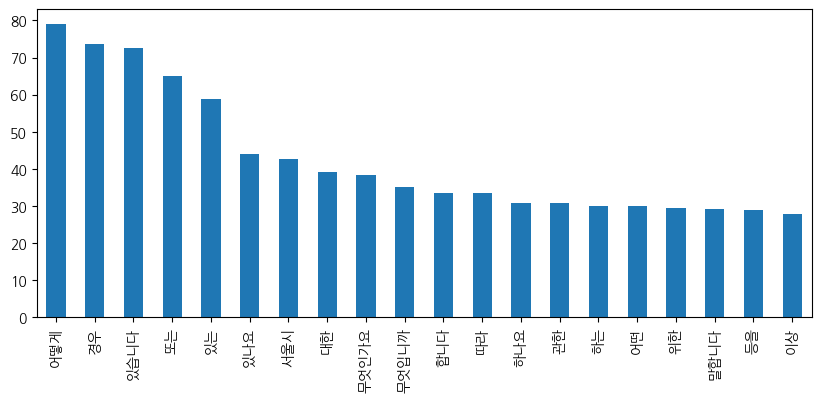

In [11]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 가중치를 적용한 vector를 확인합니다.
# df_dtm_tfidf
df_dtm_tfidf.sum().nlargest(20).plot(kind="bar", figsize=(10, 4))

## 코사인 유사도


<img src="https://i.imgur.com/RdPPH33.png">
* 이미지 출처 : https://pyimagesearch.com/

<img src="https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg">
* 이미지 출처 : https://www.learndatasci.com/glossary/cosine-similarity/




- 내적 공간 내에서 두 벡터 사이의 코사인 각도를 구하는 방법( –1∼1 사이 값을 가지며, 1에 가까울수록 유사도가 높음)
- 벡터의 크기가 아닌 방향의 유사도를 판단하는 목적으로 사용되며, 두 벡터의 방향이 완전히 같을 경우 1, 90°의 각을 이룰 경우 0, 180°로 완전히 반대 방향인 경우 -1의 값을 갖음 >> 코사인 유사도에서는 각 데이터 간의 각도가 작을 수록 데이터가 비슷
- 장점: 어떤 개수의 차원에도 적용할 수 있지만 흔히 다차원의 양수 공간에서의 유사도 측정에서 자주 이용
- 단점: 상호 상관관계를 가지는 특성(키, 몸무게 등)를 갖는 원소들간의 유사도를 계산할때에 성능이 낮음


* 코사인 유사도는 원점(모든 단어의 빈도가 0인 경우)에서 보았을 때 두 문서의 각도에 바탕을 둔 거리 측정 방식
* 내적공간의 두 벡터간 각도의 코사인값을 이용하여 측정된 벡터간의 유사한 정도를 의미한다. 각도가 0°일 때의 코사인값은 1이며, 다른 모든 각도의 코사인값은 1보다 작다. 따라서 이 값은 벡터의 크기가 아닌 방향의 유사도를 판단하는 목적으로 사용되며, 두 벡터의 방향이 완전히 같을 경우 1, 90°의 각을 이룰 경우 0, 180°로 완전히 반대 방향인 경우 -1의 값을 갖는다. 이 때 벡터의 크기는 값에 아무런 영향을 미치지 않는다. 코사인 유사도는 특히 결과값이 [0,1]의 범위로 떨어지는 양수 공간에서 사용된다.
* 코사인 유사도는 어떤 개수의 차원에도 적용이 가능하여 흔히 다차원의 양수 공간에서의 유사도 측정에 자주 이용된다. 예를 들어 정보 검색 및 텍스트 마이닝 분야에서, 단어 하나 하나는 각각의 차원을 구성하고 문서는 각 단어가 문서에 나타나는 회수로 표현되는 벡터값을 가진다. 이러한 다차원 공간에서 코사인 유사도는 두 문서의 유사를 측정하는 매우 유용한 방법이다.
* 코사인 유사도는 데이터 마이닝 분야에서 클러스터들간의 응집도를 측정하는 방법으로도 사용된다.

* 출처: https://ko.wikipedia.org/wiki/%EC%BD%94%EC%82%AC%EC%9D%B8_%EC%9C%A0%EC%82%AC%EB%8F%84
* API Document: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html



$$ \text{{Cosine Similarity}}(A, B) = \frac{{A \cdot B}}{{\|A\|\|B\|}} = \frac{{\sum^n_{i=1}A_iB_i}}{{\sqrt{\sum^n_{i=1}A_i^2}\sqrt{\sum^n_{i=1}B_i^2}}} $$


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn-metrics-pairwise-cosine-similarity

In [12]:
df_dtm_tfidf

,amp,apos,가구,가구의,가급적,가까운,가꾸기,가능,가능하나,가능하도록,...,회의실,횡단보도,효율적으로,후에,후원,훈련,휴관,휴관일,휴무,희망하는
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055109,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114472,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486628,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# sklearn.metrics.pairwise 에서 cosine_similarity 를 불러옵니다.
from sklearn.metrics.pairwise import cosine_similarity
cosine_matrix = cosine_similarity(df_dtm_tfidf, df_dtm_tfidf)
cosine_matrix

array([[1.        , 0.        , 0.03860744, ..., 0.01996438, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03860744, 0.        , 1.        , ..., 0.02681782, 0.        ,
        0.        ],
       ...,
       [0.01996438, 0.        , 0.02681782, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.319022  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.319022  ,
        1.        ]])

<Axes: >

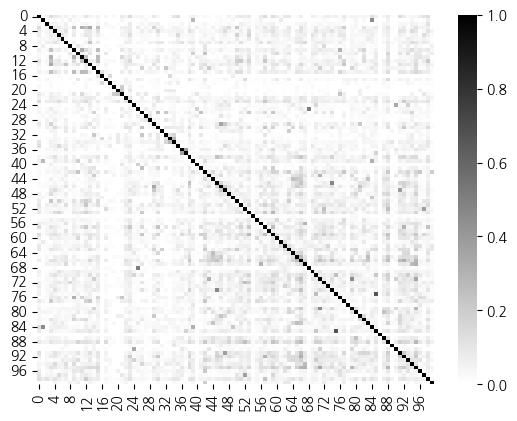

In [14]:
# heatmap cosine_matrix[:100, :100]
sns.heatmap(cosine_matrix[:100, :100], cmap="gray_r")

## 유사도가 높은 문서

In [15]:
df.shape, cosine_matrix.shape

((2645, 6), (2645, 2645))

In [16]:
# result_list를 "similarity" 파생변수로 생성하고 유사도가 높은 순으로 정렬합니다.
pd.DataFrame(cosine_matrix)[0].nlargest(10)

0       1.000000
1772    0.213216
1073    0.182389
155     0.178752
539     0.168218
1642    0.165228
2252    0.163825
2222    0.161060
141     0.152984
2095    0.152530
Name: 0, dtype: float64

In [17]:
df_consine = df[["번호", "제목"]].copy()
df_consine["similarity_0"] = pd.DataFrame(cosine_matrix)[0]
df_consine.nlargest(10, "similarity_0")

,번호,제목,similarity_0
0,2645,아빠 육아휴직 장려금,1.000000
1772,873,도시계획시설부지 재결신청 이후 진행단계는 어떤 과정을 거칩니까?,0.213216
1073,1572,부기등기 이후 제한물권 설정의 효력은?,0.182389
155,2490,[농업기술센터] 후계농업경영인 선정 및 청년창업형 후계농업경영인 신청 안내,0.178752
539,2106,행려자도 아니고 시설수용자도 아닌 사람이 살고 있던 비닐하우스에서 화상을 입었습니다...,0.168218
1642,1003,"의약품등의 제조업 폐업, 휴업인 경우 구비서류?",0.165228
2252,393,내가 가입되어 있는 보험이 무엇이 있는지 조회할수 있나요?,0.163825
2222,423,장애인을 위한 방송수신기 보급사업,0.161060
141,2504,[농업기술센터] 도시농업전문가양성교육 신청,0.152984
2095,550,서울수화전문교육원,0.152530


## 유사도가 낮은 문서

In [18]:
# 유사도가 높은 순
df_consine.nsmallest(10, "similarity_0")

,번호,제목,similarity_0
1,2644,[서울산업진흥원] 서울메이드란?,0.0
16,2629,등록된 법인의 지점이나 사업소는 별도로 등록해야 시공이 가능한가요 ?,0.0
20,2625,ESCO사업의 주요 사업분야에는 어떤게 있나요?,0.0
31,2614,3.1절 나라사랑 기념행사,0.0
32,2613,궁동체육관 FAQ,0.0
44,2601,서울 도시농업 사진전,0.0
67,2578,찾아가는 청소년 거리상담 서울시연합아웃리치,0.0
68,2577,태양광 시민펀드,0.0
90,2555,동북아 대기질개선 국제 포럼,0.0
99,2546,[건강가정지원센터] 서울가족학교 예비부부교실,0.0


### 유사도가 높은 문서 찾는 함수 만들기

In [19]:
def find_similarity(idx, n=10):
    """유사도가 높은 문서를 반환"""
    df_consine = df[["번호", "제목"]].copy()
    df_consine[f"similarity_{idx}"] = pd.DataFrame(cosine_matrix)[idx]
    return df_consine.nlargest(n, f"similarity_{idx}")

In [20]:
find_similarity(75)

,번호,제목,similarity_75
75,2570,친환경급식 안심식재료 지킴이단,1.000000
85,2560,친환경급식 안심식재료 모니터링 체험단,0.669170
70,2575,서울시 친환경 먹거리교육 학부모강사 양성과정 수강생모집,0.256972
2179,466,서울시 함께꿈 학부모단,0.187992
310,2335,"소비자식품위생감시원 및 농,수산물 명예감시원",0.183558
2531,114,서울시 생활체육지도자 채용,0.160352
1623,1022,전술적 계획이란?,0.142389
1624,1021,조직적 계획이란?,0.142389
88,2557,꽃 피는 서울상 콘테스트,0.137242
2087,558,잔류물질 모니터링 검사와 규제검사의 차이를 설명해 주세요,0.129695


## 유클리드 유사도

- 유클리드 거리(Euclidean distance)는 두 점 사이의 거리를 계산할 때 흔히 쓰는 방법으로 유클리드 공간에서의 기하학적 최단 거리(직선 거리) >> 유클리드 거리의 값이 가장 작다는 것은 문서 간 거리가 가장 가깝다는 것을 의미
- 장점: 계산하기 쉬움
- 단점: 결과 값이 1보다 큰 값이 나올 수 있으므로 값을 제한하는 과정이 필요, 분포가 다르거나 범위가 다른 경우에 상관성을 놓침
- 유클리드 거리는 두 벡터 간의 직선 거리를 계산하는 방법으로, 텍스트 데이터에 대해서는 코사인 유사도보다 덜 효과적일 수 있습니다. 
- 텍스트의 차원이 높거나 데이터가 희소할 경우, 유클리드 거리는 유용한 정보를 제공하기 어려울 수 있습니다. 따라서, 텍스트 데이터에 대한 유사도 측정에는 코사인 유사도 또는 다른 방법을 고려하는 것이 좋습니다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/DistanceFromAtoB001.svg/800px-DistanceFromAtoB001.svg.png" width="300">



$$ \text{{Euclidean Distance}}(A, B) = \sqrt{\sum^n_{i=1}(A_i - B_i)^2} $$


In [21]:
# sklearn.metrics.pairwise에서 euclidean_distances 불러오기
# 유사도값을 0~1로 만들기
#     dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
from sklearn.metrics.pairwise import euclidean_distances

# help(euclidean_distances)
ed_similarity = euclidean_distances(df_dtm_tfidf, df_dtm_tfidf)
ed_similarity.shape

(2645, 2645)

In [22]:
# 최소, 최댓값 확인
ed_similarity.min(), ed_similarity.max()

(0.0, 1.4142135623730956)

In [23]:
ed_matrix = 1 - (ed_similarity / ed_similarity.max())
ed_matrix[:10, :10].round(2)

array([[1.  , 0.  , 0.02, 0.07, 0.04, 0.04, 0.01, 0.03, 0.01, 0.03],
       [0.  , 1.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.03, 0.01],
       [0.02, 0.  , 1.  , 0.02, 0.02, 0.02, 0.01, 0.03, 0.  , 0.01],
       [0.07, 0.  , 0.02, 1.  , 0.04, 0.04, 0.02, 0.03, 0.01, 0.13],
       [0.04, 0.01, 0.02, 0.04, 1.  , 0.03, 0.02, 0.06, 0.  , 0.03],
       [0.04, 0.  , 0.02, 0.04, 0.03, 1.  , 0.05, 0.03, 0.  , 0.04],
       [0.01, 0.02, 0.01, 0.02, 0.02, 0.05, 1.  , 0.02, 0.  , 0.01],
       [0.03, 0.  , 0.03, 0.03, 0.06, 0.03, 0.02, 1.  , 0.01, 0.03],
       [0.01, 0.03, 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 1.  , 0.01],
       [0.03, 0.01, 0.01, 0.13, 0.03, 0.04, 0.01, 0.03, 0.01, 1.  ]])

<Axes: >

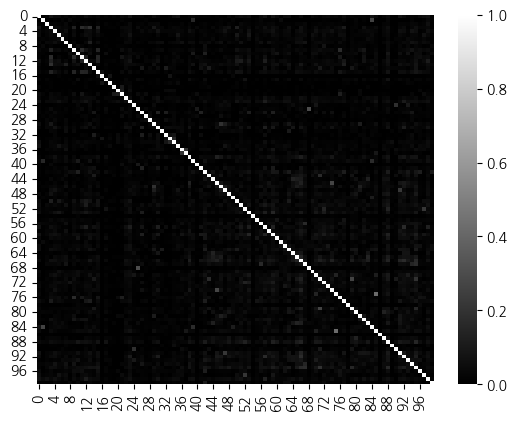

In [24]:
# heatmap (속도가 오래 걸리니 100*100 정도를 추천합니다.)
sns.heatmap(ed_matrix[:100, :100], cmap="gray")

### 유사도가 높은 문서를 반환하는 함수 만들기

In [25]:
# find_similarity_idx
def find_similarity_idx(idx, sim_matrix, n=10):
    """유사도가 높은 문서를 반환"""
    df_sim = df[["번호", "제목"]].copy()
    df_sim[f"similarity_{idx}"] = pd.DataFrame(sim_matrix)[idx]
    return df_sim.nlargest(n, f"similarity_{idx}")

In [26]:
find_similarity_idx(142, ed_matrix)

,번호,제목,similarity_142
142,2503,[농업기술센터] 국화분재 기술자 양성교육,1.000000
141,2504,[농업기술센터] 도시농업전문가양성교육 신청,0.324664
2294,351,[농업기술센터] 새해농업인실용교육,0.322105
233,2412,[농업기술센터] 귀농창업 평일반 교육 신청,0.320558
428,2217,근저당권자는 누구입니까?,0.292893
538,2107,용답동의 여자 인구는 몇 명인가요?,0.292893
579,2066,공중에 띄우는 애드벌룬은 신고대상인지?,0.292893
591,2054,"아취광고물은 허가대상입니까, 신고대상입니까?",0.292893
636,2009,행정처분을 받은자의 교육시간은?,0.292893
655,1990,보도1㎡를포장하는데몇개가소요되나요?,0.292893


## 피어슨 유사도

- 두 벡터가 주어졌을 때의 상관관계를 계산하며 각 벡터의 표본평균으로 정규화하고, 코사인 유사도를 산출하면 피어슨 유사도
- 피어슨 유사도가 1이면 양의 상관관계, -1이면 음의 상관관계, 0이면 상관관계가 없음(독립)을 의미
- 장점: 양적 변수들 사이의 선형관계를 확인하기 쉬움. 코사인 유사도의 평점 부분에 각 유저의 평균값을 뺀 값 확인 가능
- 단점: 코사인 유사도와 마찬가지로 벡터가 지닌 스칼라들의 값의 크기에 대한 고려를 하지 않음


In [ ]:
# np.corrcoef
pearson_sim = np.corrcoef(df_dtm_tfidf, df_dtm_tfidf)
pearson_sim

In [28]:
pearson_sim.min(), pearson_sim.max()

(nan, nan)

In [29]:
pearson_sim[:10, :10]

array([[ 1.        , -0.007145  ,  0.02998117,  0.13132428,  0.06876288,
         0.06351726,  0.0133573 ,  0.04742516,  0.00771254,  0.04282372],
       [-0.007145  ,  1.        , -0.00444795, -0.00704035,  0.01478903,
        -0.0076387 ,  0.02650838, -0.00684132,  0.0620877 ,  0.00758098],
       [ 0.02998117, -0.00444795,  1.        ,  0.02520446,  0.03633173,
         0.02270414,  0.0090217 ,  0.05612094, -0.00507435,  0.01410659],
       [ 0.13132428, -0.00704035,  0.02520446,  1.        ,  0.06460435,
         0.05504576,  0.033615  ,  0.04368266,  0.01695018,  0.22412563],
       [ 0.06876288,  0.01478903,  0.03633173,  0.06460435,  1.        ,
         0.03839007,  0.03560174,  0.09743454, -0.00831906,  0.04800388],
       [ 0.06351726, -0.0076387 ,  0.02270414,  0.05504576,  0.03839007,
         1.        ,  0.08765638,  0.03669509, -0.00201258,  0.06266443],
       [ 0.0133573 ,  0.02650838,  0.0090217 ,  0.033615  ,  0.03560174,
         0.08765638,  1.        ,  0.02281683

<Axes: >

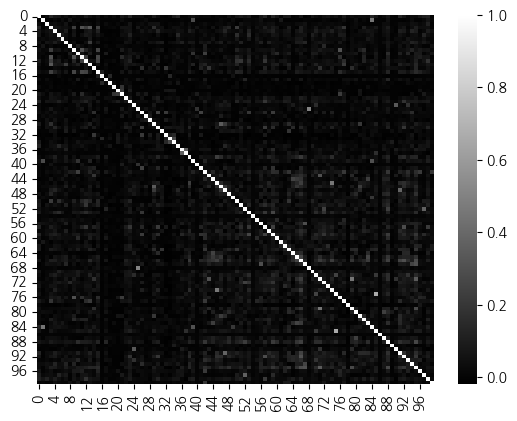

In [30]:
# heatmap
sns.heatmap(pearson_sim[:100, :100], cmap="gray")

In [31]:
# find_similarity_idx
def find_similarity_idx(idx, sim_matrix, n=10):
    """유사도가 높은 문서를 반환"""
    df_sim = df[["번호", "제목"]].copy()
    df_sim[f"similarity_{idx}"] = pd.DataFrame(sim_matrix)[idx]
    return df_sim.nlargest(n, f"similarity_{idx}")

In [32]:
find_similarity_idx(10, pearson_sim)

,번호,제목,similarity_10
10,2635,서울시 사회서비스원은 무엇을 하는 곳인가요?,1.000000
2596,49,농업기술센터는 무엇을 하는곳입니까?,0.471389
1192,1453,입법예고는 무엇을 예고하나요?,0.452166
511,2134,방재란 무엇을 말합니까?,0.427348
1787,858,도시계획시설부지로 지장물이란 무엇을 의미합니까?,0.364850
1390,1255,서울시 연수시설의 각 홈페이지 주소를 알려주세요,0.363219
1385,1260,명절휴가비란 무엇을 말하나요?,0.326393
2084,561,지역별 전문건설회관(전문건설공제조합) 위치 안내,0.313086
2477,168,서울시 차량통행속도조사 결과자료는 어디에서 얻을 수 있나요?,0.307769
1966,679,행정서포터스에 참여하고 싶은데 혹시 올해도 행정서포터스 계획이 있으신지요?,0.299617


## 자카드 유사도

* 자카드 지수(Jaccard index)는 두 집합 사이의 유사도를 측정하는 방법 중 하나이다. 자카드 계수(Jaccard coefficient) 또는 자카드 유사도(Jaccard similarity)라고도 한다. 자카드 지수는 0과 1 사이의 값을 가지며, 두 집합이 동일하면 1의 값을 가지고, 공통의 원소가 하나도 없으면 0의 값을 가진다.
- 두 문장을 각 단어의 집합으로 생성 한 뒤, 생성된 집합을 통해 유사도를 측정(고객 간 유사도)
- 0,1의 바이너리 데이터로 만든 이후에, 합집합과 교집합 사이의 비율로 나타냄(집합의 개념을 이용)
- 얼마나 많은 아이템을 동시에 갖고 있는가?를 수치로 환산하며, 함께 갖고 있는 아이템이 없다면 0, 아이템 전체가 겹치면 1로 계산
- 장점: 대표적인 이진 평가(binary feedback)에 대한 유사도를 측정할 수 있는 지표, 동시출현빈도(co-occurrence) 고려
- 단점: 데이터가 순서나 양을 갖는 집합 데이터라면 낮은 성능을 보임


<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png" width="500">

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png" width="500">



$$ \text{{Jaccard Similarity}}(A, B) = \frac{{|A \cap B|}}{{|A \cup B|}} $$

In [33]:
# sklearn.metrics.pairwise 에서 pairwise_distances 불러오기
from sklearn.metrics.pairwise import pairwise_distances

jaccard_matrix = pairwise_distances(dtm.toarray(), dtm.toarray(), metric="jaccard")
jaccard_matrix[:10, :10].round(2)

/Users/corazzon/codes/jupyter/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


array([[0.  , 1.  , 0.93, 0.86, 0.95, 0.92, 0.95, 0.94, 0.98, 0.95],
       [1.  , 0.  , 1.  , 1.  , 0.98, 1.  , 0.95, 1.  , 0.93, 0.99],
       [0.93, 1.  , 0.  , 0.91, 0.93, 0.91, 0.92, 0.86, 1.  , 0.94],
       [0.86, 1.  , 0.91, 0.  , 0.93, 0.9 , 0.97, 0.95, 0.97, 0.9 ],
       [0.95, 0.98, 0.93, 0.93, 0.  , 0.93, 0.92, 0.91, 1.  , 0.93],
       [0.92, 1.  , 0.91, 0.9 , 0.93, 0.  , 0.91, 0.95, 0.99, 0.89],
       [0.95, 0.95, 0.92, 0.97, 0.92, 0.91, 0.  , 0.95, 0.97, 0.95],
       [0.94, 1.  , 0.86, 0.95, 0.91, 0.95, 0.95, 0.  , 0.98, 0.96],
       [0.98, 0.93, 1.  , 0.97, 1.  , 0.99, 0.97, 0.98, 0.  , 0.96],
       [0.95, 0.99, 0.94, 0.9 , 0.93, 0.89, 0.95, 0.96, 0.96, 0.  ]])

In [34]:
jaccard_matrix.min(), jaccard_matrix.max()

(0.0, 1.0)

In [35]:
jaccard_sim = (1 - jaccard_matrix)
jaccard_sim

array([[1.        , 0.        , 0.06896552, ..., 0.02272727, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06896552, 0.        , 1.        , ..., 0.02380952, 0.        ,
        0.        ],
       ...,
       [0.02272727, 0.        , 0.02380952, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.1875    ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.1875    ,
        1.        ]])

<Axes: >

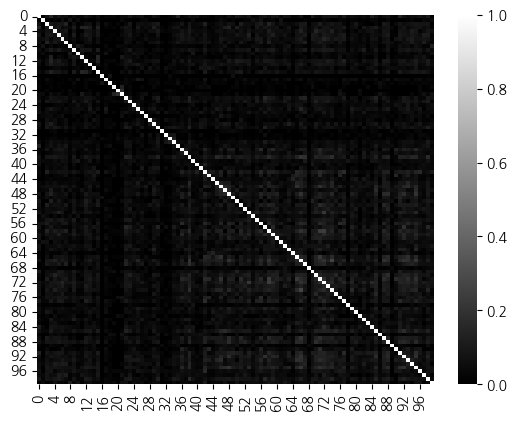

In [36]:
# heatmap (속도가 오래 걸리니 100*100 정도를 추천합니다.)
sns.heatmap(jaccard_sim[:100, :100], cmap="gray")

In [37]:
find_similarity_idx(100, jaccard_sim)

,번호,제목,similarity_100
100,2545,장애인 IT챌린지,1.000000
47,2598,장애인 수영 한강건너기 대회,0.152542
66,2579,목재감성 체험 박람회 (서울 목공 한마당),0.138889
29,2616,금천 나도스타 노래부르기 대회 (어린이날 행사),0.129630
48,2597,청계천 어린이 미술대회,0.125000
95,2550,[서울시립청소년미디어센터] 미디어스토리 캠프,0.112903
88,2557,꽃 피는 서울상 콘테스트,0.109890
96,2549,"시도행정시스템,시군구행정시스템 관련 업무",0.105263
25,2620,아파트 태양광 설치 및 에너지절약 활성화 포럼,0.100000
83,2562,2016년 서울 템플스테이 위크(week),0.100000
